In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#writing down all the imports at the start to be safe :)
!pip install tensorflow
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/hindi_word_lemma.csv')
df.head(5)

,Word,Lemma
0,लोग,लोग
1,‘कैप्चा’,‘कैप्चा’
2,के,के
3,जरिए,जर
4,अक्षरों,अक्षर


In [ ]:
pip install indic-transliteration


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from indic_transliteration import sanscript
from indic_transliteration.sanscript import transliterate

def enclose_in_quotes(text):
    return f"'{text}'"

df['Word'] = df['Word'].apply(enclose_in_quotes)
df['Lemma'] = df['Lemma'].apply(enclose_in_quotes)
def transliterate_to_roman(text):
    return transliterate(text, sanscript.DEVANAGARI, sanscript.ITRANS)

df['Word_Roman'] = df['Word'].apply(transliterate_to_roman)
df['Lemma_Roman'] = df['Lemma'].apply(transliterate_to_roman)
print(df)


                    Word              Lemma          Word_Roman  \
0                  'लोग'              'लोग'              'loga'   
1             '‘कैप्चा’'         '‘कैप्चा’'         '‘kaipchA’'   
2                   'के'               'के'                'ke'   
3                 'जरिए'               'जर'             'jarie'   
4              'अक्षरों'            'अक्षर'          'akSharoM'   
...                  ...                ...                 ...   
17346          'रेडिएंट'          'रेडिएंट'          'reDieMTa'   
17347            'स्यान'            'स्यान'             'syAna'   
17348           'मार्बल'           'मार्बल'           'mArbala'   
17349  'स्टेब्लिलाईजेशन'  'स्टेब्लिलाईजेशन'  'sTeblilAIjeshana'   
17350         'ग्रेफाइल'         'ग्रेफाइल'         'grephAila'   

              Lemma_Roman  
0                  'loga'  
1             '‘kaipchA’'  
2                    'ke'  
3                  'jara'  
4               'akShara'  
...                   ...  

In [ ]:
df.drop(columns=['Word', 'Lemma'], inplace=True)

In [ ]:
df.rename(columns={'Word_Roman': 'Word', 'Lemma_Roman': 'Lemma'}, inplace=True)
df

,Word,Lemma
0,'loga','loga'
1,'‘kaipchA’','‘kaipchA’'
2,'ke','ke'
3,'jarie','jara'
4,'akSharoM','akShara'
...,...,...
17346,'reDieMTa','reDieMTa'
17347,'syAna','syAna'
17348,'mArbala','mArbala'
17349,'sTeblilAIjeshana','sTeblilAIjeshana'


In [ ]:
df1=df
df1['Word'] = df1['Word'].str.replace("'", "")
df1['Lemma'] = df1['Lemma'].str.replace("'", "")
df2 = pd.read_csv('/content/drive/MyDrive/Verb.csv',sep='\t')
df2.columns = ['Word','Lemma']
print(df2.head(5))

   Word Lemma
0  said   say
1   was    be
2    be    be
3   are    be
4  have  have


In [ ]:
frames = [df1, df2]
df = pd.concat(frames)
df

,Word,Lemma
0,loga,loga
1,‘kaipchA’,‘kaipchA’
2,ke,ke
3,jarie,jara
4,akSharoM,akShara
...,...,...
49503,HURLING,hurl
49504,quess,ques
49505,Dethroning,dethrone
49506,bedazzles,bedazzle


In [ ]:
df['Word'] = df['Word'].astype(str)
df['Lemma'] = df['Lemma'].astype(str)

In [ ]:
word_tokenizer = Tokenizer(char_level=True)
lemma_tokenizer = Tokenizer(char_level=True)
word_tokenizer.fit_on_texts(df['Word'])
lemma_tokenizer.fit_on_texts(df['Lemma'])
word_sequences = word_tokenizer.texts_to_sequences(df['Word'])
lemma_sequences = lemma_tokenizer.texts_to_sequences(df['Lemma'])
max_seq_length = max(max(len(seq) for seq in word_sequences), max(len(seq) for seq in lemma_sequences))
X = pad_sequences(word_sequences, maxlen=max_seq_length, padding='post')
y = pad_sequences(lemma_sequences, maxlen=max_seq_length, padding='post')
y = tf.keras.utils.to_categorical(y, num_classes=len(lemma_tokenizer.word_index) + 1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
num_classes = len(lemma_tokenizer.word_index) + 1
model = Sequential([
    Embedding(input_dim=len(word_tokenizer.word_index) + 1, output_dim=64, input_length=max_seq_length),
    LSTM(units=128, return_sequences=True),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 35, 64)            4288      
                                                                 
 lstm_3 (LSTM)               (None, 35, 128)           98816     
                                                                 
 dense_3 (Dense)             (None, 35, 69)            8901      
                                                                 
Total params: 112005 (437.52 KB)
Trainable params: 112005 (437.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
753/753 [==============================] - 67s 86ms/step - loss: 0.4834 - accuracy: 0.8951 - val_loss: 0.0847 - val_accuracy: 0.9809
Epoch 2/10
753/753 [==============================] - 61s 82ms/step - loss: 0.0624 - accuracy: 0.9845 - val_loss: 0.0541 - val_accuracy: 0.9863
Epoch 3/10
753/753 [==============================] - 78s 104ms/step - loss: 0.0483 - accuracy: 0.9875 - val_loss: 0.0458 - val_accuracy: 0.9883
Epoch 4/10
753/753 [==============================] - 61s 81ms/step - loss: 0.0424 - accuracy: 0.9889 - val_loss: 0.0414 - val_accuracy: 0.9892
Epoch 5/10
753/753 [==============================] - 62s 83ms/step - loss: 0.0386 - accuracy: 0.9897 - val_loss: 0.0383 - val_accuracy: 0.9899
Epoch 6/10
753/753 [==============================] - 62s 83ms/step - loss: 0.0357 - accuracy: 0.9904 - val_loss: 0.0363 - val_accuracy: 0.9904
Epoch 7/10
753/753 [==============================] - 62s 83ms/step - loss: 0.0334 - accuracy: 0.9908 - val_loss: 0.0341 - val_accuracy

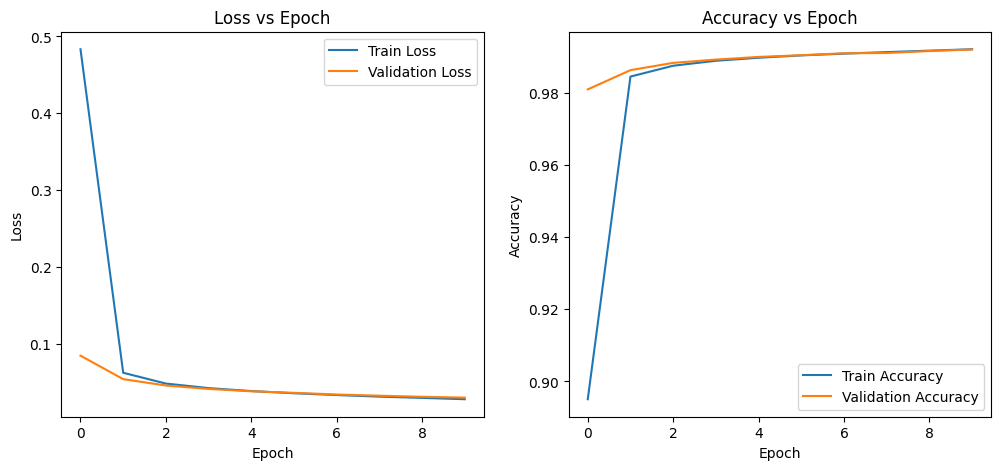

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.show()

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

418/418 [==============================] - 9s 23ms/step - loss: 0.0293 - accuracy: 0.9921
Test Accuracy: 0.9920921921730042


In [ ]:
import numpy as np
def predict_lemma(word):
    seq = word_tokenizer.texts_to_sequences([word])
    padded_seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
    pred = model.predict(padded_seq)
    pred_seq = np.argmax(pred, axis=-1)[0]
    pred_text = ''.join(lemma_tokenizer.index_word[idx] for idx in pred_seq if idx != 0)
    return pred_text

def predict_lemmas(sentence):
    words = sentence.split()
    lemmas = [predict_lemma(word) for word in words]
    return ' '.join(lemmas)

sentence1 = "Bachche khilone lekar park mein khel rahe hain"
predicted_lemmas = predict_lemmas(sentence1)
print(predicted_lemmas)

sentence2 = "Mujhe jaanne ki zarurat hai ke this week kya koi murder mystery parties hai"
predicted_lemmas = predict_lemmas(sentence2)
print(predicted_lemmas)

sentence3 = "Tomorrow noon mere dry cleaning lene ka yad dilae"
predicted_lemmas = predict_lemmas(sentence3)
print(predicted_lemmas)

sentence4 = "kya mere idhar koi themed parties chalrahi hai"
predicted_lemmas = predict_lemmas(sentence4)
print(predicted_lemmas)

sentence5 = "All Time aksharom ke saarey songs order se bajaiye"
predicted_lemmas = predict_lemmas(sentence5)
print(predicted_lemmas)

sentence6 = "Mujhe saare events ki list do jo Phoneix area me hone wale hai this month"
predicted_lemmas = predict_lemmas(sentence6)
print(predicted_lemmas)

1/1 [==============================] - 0s 23ms/step
bachch khilan lekar park mein khel rahe hain
1/1 [==============================] - 0s 24ms/step
mujhe jaanne ki zarurat hai ke this week kya koi murder mystery partie hai
1/1 [==============================] - 0s 25ms/step
tomorrow noon mere dry clean lene ka yad dilae
1/1 [==============================] - 0s 30ms/step
kya mere idhar koi theme partie chalrahi hai
1/1 [==============================] - 0s 24ms/step
all time akshara ke saary song order se bajaiy
1/1 [==============================] - 0s 26ms/step
mujhe saar event ki list do jo phonex area me hone wale hai this month
